In [1]:
%cd ..

f:\DS Lab\OT\ot-kpgg-fc


C:\Users\ngtdu\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
import numpy as np
import os
import ot
from sklearn.cluster import KMeans
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from optimal_transport.models import KeypointFOT

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import ot.plot
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_data(num=20):
    np.random.seed(3)
    source = []
    target = []
    centers = [np.array([[-1,-1]]),np.array([[-3,2]]),np.array([[-2,3]]),
               np.array([[0,1]]),np.array([[-0.5,0.5]]),np.array([[-1,2]])]
    for i in range(3):
        source.append(np.random.multivariate_normal(np.array([0,0]),cov=0.05*np.array([[1,0],[0,1]]),size=num)+centers[i])
        target.append(
            np.random.multivariate_normal(np.array([0, 0]), cov=0.05 * np.array([[1, 0], [0, 1]]), size=num) + centers[
                i+3])
    return source,target

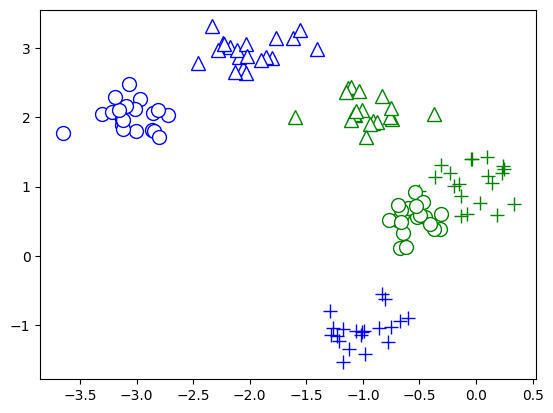

In [4]:
num = 20
source_,target_ = get_data(num)
s = ["+","o","^"]
# plot data
for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

Threshold reached at iteration 4
[[-0.49033737 -0.51171156]
 [-1.20821583  1.64000785]
 [-1.49818917  0.91731907]
 [-0.52260062  0.13569538]
 [-1.5895745   2.79936603]
 [-1.8851273   1.38660705]
 [-0.52260062  0.13569538]
 [-1.5895745   2.79936603]
 [-1.8851273   1.38660705]
 [-1.5895745   2.79936603]
 [-1.8851273   1.38660705]
 [-0.52260062  0.13569538]]
Matching accuracy:100.0%


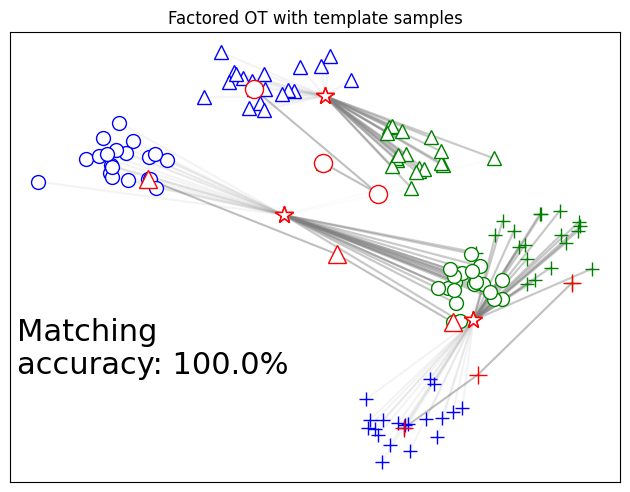

In [16]:
source = np.vstack(source_)
target = np.vstack(target_)

plt.xticks([])
plt.yticks([])
plt.tight_layout()

n_anchors = 3
p = np.ones(len(source))/len(source)
q = np.ones(len(target))/len(target)

I = [3, 2*num+6, num+1]
J = [8, 2*num+13, num+1]
K = list(zip(I, J))

model = KeypointFOT(n_free_anchors=3*n_anchors, alpha=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200)

result = model.fit(source, target, p, q, K)
Px = result.Pa_
Py = result.Pb_
P = Px.dot(Py)
M = result.z_
print(M)
I, L, J = result._init_keypoint_inds(K)
# Px = Px.detach().numpy()
# Py = Py.detach().numpy()

ot.plot.plot2D_samples_mat(source, M, Px, c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(M, target, Py, c="grey", alpha=0.5)

s = ["+","o","^","o","+","^"]
t = 3
for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")
# plot anchors
for i in range(len(M)):
    if i not in L:
        plt.plot(np.vstack(M)[i][0], np.vstack(M)[i][1],'r*', markersize=10+t, markerfacecolor="white")
# plot keypoints
for i in range(len(I)):
    plt.plot(np.vstack(source)[I[i]][0], np.vstack(source)[I[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")
    plt.plot(np.vstack(target)[J[i]][0], np.vstack(target)[J[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")
    plt.plot(np.vstack(M)[L[i]][0], np.vstack(M)[L[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")

if not os.path.exists("figure"):
    os.makedirs("figure")
pl.title('Factored OT with template samples')

labels = [0]*num + [1]*num + [2]*num
labels = np.array(labels)
pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
plt.savefig("figure/KP.pdf")
plt.show()
